# Lung Segmentation using Computer Vision

The objective of this is to explore an expedient image segmentation algorithm for medical images to curtail the physicians interpretation of computer tomography (CT) scan images. Modern medical imaging modalities generate large images that are extremely grim to analyze manually. The consequences of segmentation algorithms rely on the exactitude and convergence time. At this moment, there is a compelling necessity to explore and implement new evolutionary algorithms to solve the problems associated with medical image segmentation. Lung cancer is the frequently diagnosed cancer across the world among men. Early detection of lung cancer navigates towards apposite treatment to save human lives. CT is one of the modest medical imaging methods to diagnose the lung cancer. In the present study, the performance of five optimization algorithms, namely, k-means clustering, k-median clustering, particle swarm optimization, inertia-weighted particle swarm optimization, and guaranteed convergence particle swarm optimization (GCPSO), to extract the tumor from the lung image has been implemented and analyzed. The performance of median, adaptive median, and average filters in the preprocessing stage was compared, and it was proved that the adaptive median filter is most suitable for medical CT images. Furthermore, the image contrast is enhanced by using adaptive histogram equalization. The preprocessed image with improved quality is subject to four algorithms. The practical results are verified for 20 sample images of the lung using MATLAB, and it was observed that the GCPSO has the highest accuracy of 95.89%.

### CT imaging:
#### Physics of CT Scans

Computed Tomography (CT) uses X-ray beams to obtain 3D pixel intensities of the human body. A heated cathode releases high-energy beams (electrons), which in turn release their energy as X-ray radiation. X-rays pass through human body tissues and hits a detector on the other side. A dense tissue (i.e. bones) will absorb more radiation than soft tissues (i.e. fat). When X-rays are not absorbed from the body (i.e. in the air region inside the lungs) and reach the detector we see them as black, similar to a black film. On the opposite, dense tissues are depicted as white.


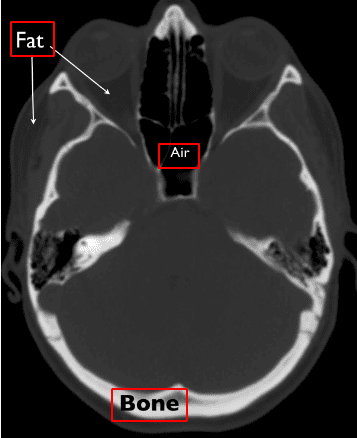

### CT intensities and Hounsfield units

The X-ray absorption is measured in the Hounsfield scale. In this scale, we fix the Air intensity to -1000 and water to 0 intensity. It is essential to understand that Housenfield is an absolute scale, unlike MRI where we have a relative scale from 0 to 255.

The image illustrates some of the basic tissues and their corresponding intensity values. Keep in mind that the images are noisy. The numbers may slightly vary in real images.

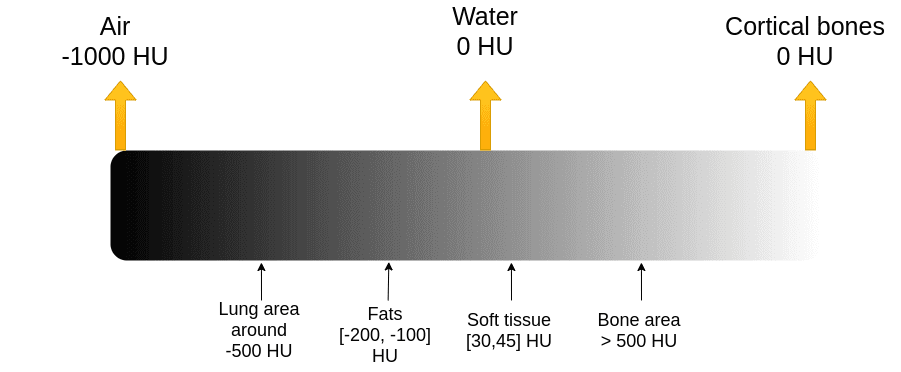

Bones have high intensity. We usually clip the image to have an upper maximum range. For instance, the max value might be 1000, for practical reasons.

The problem: visualization libraries work on the scale [0,255]. It wouldn’t be very wise to visualize all the Hounsfield scale (from -1000 to 1000+ ) to 256 scales for medical diagnosis.

Instead, we limit our attention to different parts of this range and focus on the underlying tissues.

### CT data visualization: level and window

The medical image convention to clip the Housenfield range is by choosing a central intensity, called level and a window, as depicted:

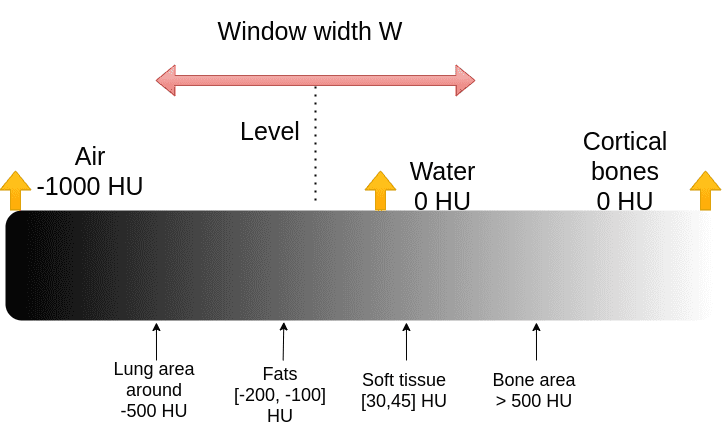

It is actually quite an ugly convention for computer scientists. We would just like the min and max of the range:

max = level + window/2max=level+window/2

min = level - window/2min=level−window/2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
def show_slice_window(slice, level, window):
   """
   Function to display an image slice
   Input is a numpy 2D array
   """
   max = level + window/2
   min = level - window/2
   slice = slice.clip(min,max)
   plt.figure()
   plt.imshow(slice.T, cmap="gray", origin="lower")
   plt.savefig('L'+str(level)+'W'+str(window))

### Lung segmentation based on intensity values

We will not just segment the lungs but we will also find the real area in mm^2. To do that we need to find the real size of the pixel dimensions. Each image may have a different one.

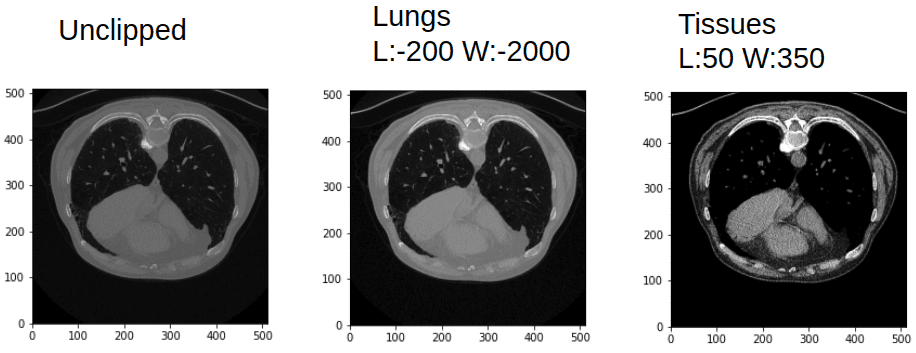

### Step 1: Find pixel dimensions to calculate the area in mm^2

In [5]:
def find_pix_dim(ct_img):
    """
    Get the pixdim of the CT image.
    A general solution that gets the pixdim indicated from the image dimensions. From the last 2 image dimensions, we get their pixel dimension.
    Args:
        ct_img: nib image

    Returns: List of the 2 pixel dimensions
    """
    pix_dim = ct_img.header["pixdim"] # example [1,2,1.5,1,1]
    dim = ct_img.header["dim"] # example [1,512,512,1,1]
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(dim, max_indx)
    pix_dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY] # example [2, 1.5]

### Step 2: Binarize image using intensity thresholding

We expect lungs to be in the Housendfield unit range of [-1000,-300]. To this end, we need to clip the image range to [-1000,-300] and binarize the values to 0 and 1.

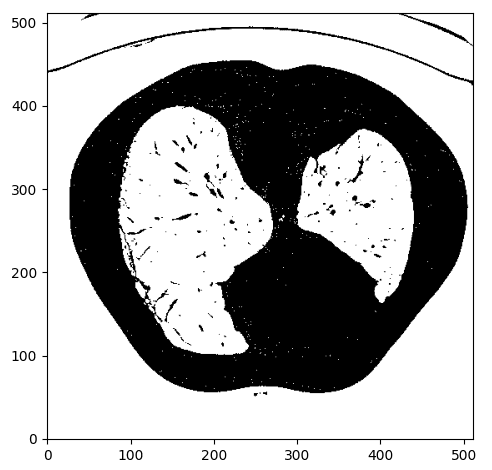

### Step 3: Contour finding

We care about the lung regions that are shown on white. If we could find an algorithm to identify close sets or any kind of contours in the image that may help. After some search online, I found the marching squares method that finds constant valued contours in an image from skimage, called skimage.measure.find_contours().

After using this function I visualize the detected contours in the original CT image

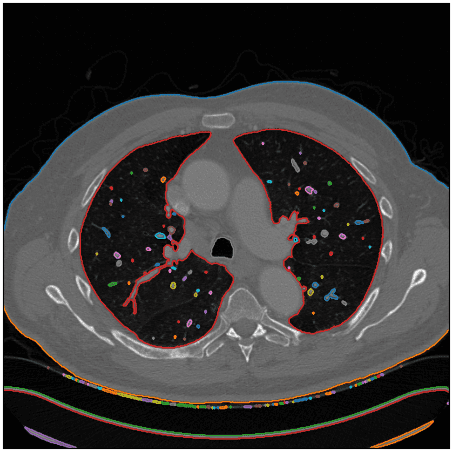

In [6]:
def intensity_seg(ct_numpy, min=-1000, max=-300):
   clipped = clip_ct(ct_numpy, min, max)
   return measure.find_contours(clipped, 0.95)

### Step 4: Find the lung area from a set of possible contours

Note that I used a different image to show an edge case that the patient’s body is not a closed set of points. Ok, not exactly what we want, but let’s see if we could work that out.
To do so, I first extracted a convex polygon from the contour using scipy. After I assume 2 constraints:

The contour of the lungs must be a closed set (always true)

The contour must have a minimum volume of 2000 pixels to represent the lungs.

That may or may not include the body contour, resulting in more than 3 contours. When that happens the body is easily discarded by having the largest volume of the contour that satisfies the pre-described assumptions.

In [7]:
def find_lungs(contours):
    """
    Chooses the contours that correspond to the lungs and the body
    First, we exclude non-closed sets-contours
    Then we assume some min area and volume to exclude small contours
    Then the body is excluded as the highest volume closed set
    The remaining areas correspond to the lungs
    Args:
        contours: all the detected contours

    Returns: contours that correspond to the lung area
    """
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

       # set some constraints for the volume
        if hull.volume > 2000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)

    # Discard body contour
    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        vol_contours, body_and_lung_contours = (list(t) for t in
                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1) # body is out!
    return body_and_lung_contours # only lungs left !!!

As an edge case, I am showing that the algorithm is not restricted to only two regions of the lungs.

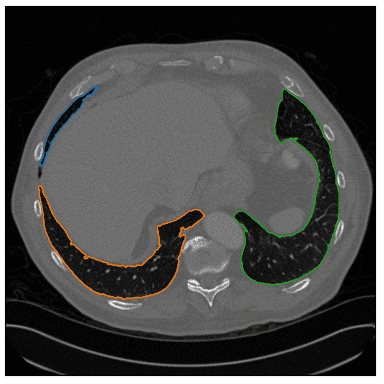

### Step 5: Contour to binary mask

Next, we save it as a nifty file so we need to convert the set of points to a lung binary mask. For this, I used the pillow python lib that draws a polygon and creates a binary image mask. Then I merge all the masks of the already found lung contours.

In [8]:
import numpy as np
from PIL import Image, ImageDraw
def create_mask_from_polygon(image, contours):
    """
    Creates a binary mask with the dimensions of the image and
    converts the list of polygon-contours to binary masks and merges them together
    Args:
        image: the image that the contours refer to
        contours: list of contours

    Returns:

    """
    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary
    return lung_mask.T  # transpose it to be aligned with the image dims

The desired lung area in mm^2 is simply the number of nonzero elements multiplied by the two pixel dimensions of the corresponding image.

The lung areas are saved in a csv file along with the image name.

Finally, to save the mask as nifty I used the value of 255 for the lung area instead of 1 to be able to display in a nifty viewer. Moreover, I save the image with the affine transformation of the initial CT slice to be able to be displayed meaningfully (aligned without any rotation conflicts).

In [9]:
def save_nifty(img_np, name, affine):
    """
    binary masks should be converted to 255 so it can be displayed in a nii viewer
    we pass the affine of the initial image to make sure it exits in the same
    image coordinate space
    Args:
        img_np: the binary mask
        name: output name
        affine: 4x4 np array
    Returns:
    """
    img_np[img_np == 1] = 255
    ni_img = nib.Nifti1Image(img_np, affine)
    nib.save(ni_img, name + '.nii.gz')

Finally, I opened the mask with a common nifty viewer for Linux to validate that everything went ok. Here are snapshots for slice number 4:

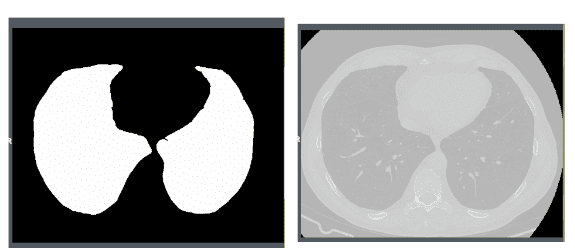

### Segment the main vessels and compute the vessels over lung area ratio

First, we do element-wise multiplication between the CT image and the lung mask to get only the lungs. Afterwards, we set the zeros that resulted from the element-wise multiplication to -1000 (AIR in HU) and finally keep only the intensities that are bigger than -500 as vessels.

In [10]:
def create_vessel_mask(lung_mask, ct_numpy, denoise=False):
    vessels = lung_mask * ct_numpy  # isolate lung area
    vessels[vessels == 0] = -1000
    vessels[vessels >= -500] = 1
    vessels[vessels < -500] = 0
    show_slice(vessels)
    if denoise:
        return denoise_vessels(lungs_contour, vessels)
    show_slice(vessels)
    return vessels

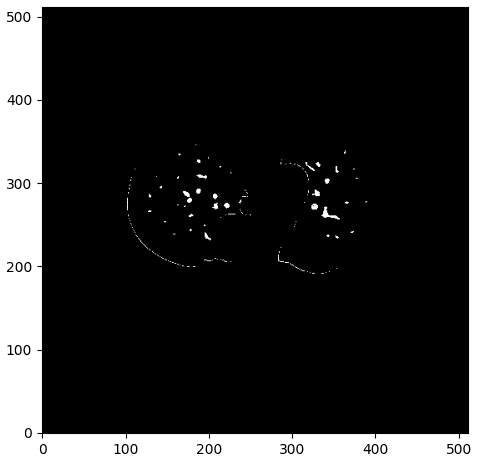

### Analyzing and improving the segmentation’s result

As you can see we have some parts of the contour of the lungs, which I believe we would like to avoid. To this end, I created a denoising function that considers the distance of the mask to all the contour points. If it is below 0.1, I set the pixel value to 0 and as a result exclude them from the detected vessels.

In [11]:
def denoise_vessels(lung_contour, vessels):
    vessels_coords_x, vessels_coords_y = np.nonzero(vessels)  # get non zero coordinates
    for contour in lung_contour:
        x_points, y_points = contour[:, 0], contour[:, 1]
        for (coord_x, coord_y) in zip(vessels_coords_x, vessels_coords_y):
            for (x, y) in zip(x_points, y_points):
                d = euclidean_dist(x - coord_x, y - coord_y)
                if d <= 0.1:
                    vessels[coord_x, coord_y] = 0
    return vessels

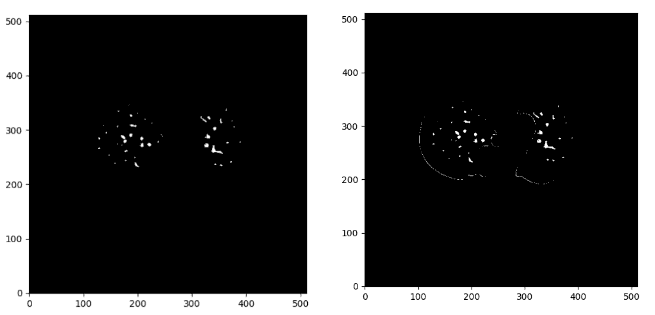

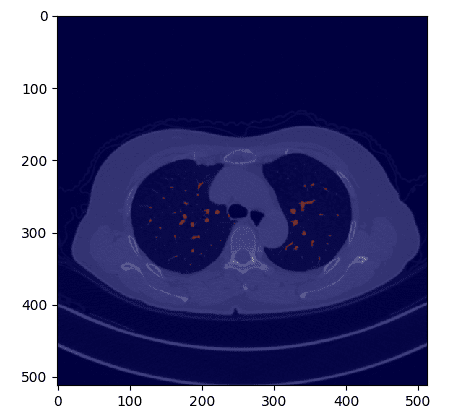

In [12]:
def overlay_plot(im, mask):
    plt.figure()
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.5)

Now that we have the mask, the vessel area is computed similar to what I did for the lungs, by taking into account the individual image pixel dimension.

In [13]:
def compute_area(mask, pixdim):
    """
    Computes the area (number of pixels) of a binary mask and multiplies the pixels
    with the pixel dimension of the acquired CT image
    Args:
        lung_mask: binary lung mask
        pixdim: list or tuple with two values

    Returns: the lung area in mm^2
    """
    mask[mask >= 1] = 1
    lung_pixels = np.sum(mask)
    return lung_pixels * pixdim[0] * pixdim[1]

### Conclusion
 Best imaging technique CT imaging are reliable for lung cancer diagnosis because it can disclose every suspected and unsuspected lung cancer nodules. 